In [ ]:
from dotenv import load_dotenv
load_dotenv()

h4g43XUVoM9phd3GnHCWYsKtV4HBdz9f


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
# node -> agent -> market researcher
#               -> 주식조사 (차트)        -> 투자 결정
#               -> 재무재표 - yfinance

In [4]:
%pip install --upgrade --quiet yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Literal

from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

polygon = PolygonAPIWrapper()
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tools = toolkit.get_tools()
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a market researcher. Provide facts only, not opinions."),
    MessagesPlaceholder("messages"),
])

market_research_tools = [YahooFinanceNewsTool()] + polygon_tools

market_research_agent = create_react_agent(
    llm,
    tools=market_research_tools,
    prompt=prompt,
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = market_research_agent.invoke(state)
    print(f'market_research_node: {result}')
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name= 'market_research')]},
        goto="supervisor"
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.
C:\Users\jo\AppData\Local\Temp\ipykernel_37840\39393441.py:22: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  market_research_agent = create_react_agent(


In [6]:
import yfinance as yf
from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> str:
    """Given a stock ticker, return the price data for the past 10 days"""
    stock_info = yf.download(ticker, period="1mo").to_dict()
    return stock_info

stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm,
    tools=stock_research_tools,
    prompt=prompt,
)


def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = stock_research_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name= 'stock_research')]},
        goto="supervisor"
    )

C:\Users\jo\AppData\Local\Temp\ipykernel_37840\1697809157.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  stock_research_agent = create_react_agent(


In [7]:
@tool
def company_research_tool(company_name: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(company_name)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        "financial_info": financial_info,
        "sec_filings": sec_filings
    }

company_research_tool = [company_research_tool]
company_research_agent = create_react_agent(
    llm,
    tools=company_research_tool,
    prompt=prompt,
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = company_research_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name= 'company_research')]},
        goto="supervisor"
    )

C:\Users\jo\AppData\Local\Temp\ipykernel_37840\2286290999.py:13: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  company_research_agent = create_react_agent(


In [ ]:
from langchain_core.prompts import PromptTemplate
analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide whether to buy, sell, or hold the stock.

Information:
{messages}"""
)
analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)


graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

In [ ]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()

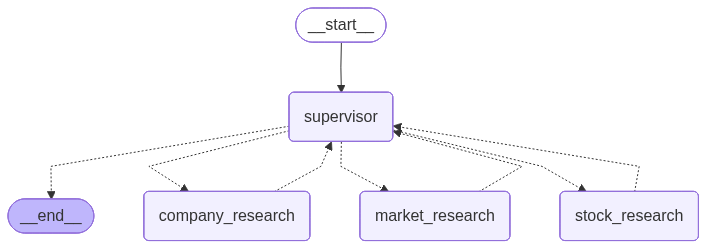

In [11]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [12]:
for chunk in graph.stream(
  {'messages': [("user", "Would you invest in Snowflake")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake
market_research_node: {'messages': [HumanMessage(content='Would you invest in Snowflake', additional_kwargs={}, response_metadata={}, id='a6d72f3d-5e82-4ffb-9d42-945202d36b4e'), AIMessage(content='I cannot provide investment advice or opinions. However, I can provide you with factual information about Snowflake, such as its recent financial performance, stock price trends, and news. Let me know what specific information you would like to know about Snowflake.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 513, 'total_tokens': 564, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_finge

ValueError: API Error: {'status': 'NOT_AUTHORIZED', 'request_id': 'c03bfbe449f58c95d097a28da96d73cf', 'message': 'You are not entitled to this data. Please upgrade your plan at https://polygon.io/pricing'}